In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
import shutil
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [2]:
def create_data_path(base_path,input_path):
    try:
        os.makedirs(os.path.join(base_path,'training'))
        os.makedirs(os.path.join(base_path, 'training/0'))
        os.makedirs(os.path.join(base_path, 'training/1'))
        os.makedirs(os.path.join(base_path,'validation'))
        os.makedirs(os.path.join(base_path, 'validation/1'))
        os.makedirs(os.path.join(base_path, 'validation/0'))
    except:
        print("Le folder esistono già")
    list_dir=glob.glob(os.path.join(input_path,'*'))
    print(list_dir)
    for id in list_dir:
        list_file_0=glob.glob(os.path.join(id,'0/*'))
        list_file_1= glob.glob(os.path.join(id, '1/*'))
        for file_0 in list_file_0:
            src_path = file_0
            dst_path = os.path.join(os.path.join(base_path, 'training/0'), os.path.basename(file_0))
            shutil.copy(src_path, dst_path)

        for file_1 in list_file_1:
            src_path = file_1
            dst_path = os.path.join(os.path.join(base_path, 'training/1'), os.path.basename(file_1))
            shutil.copy(src_path, dst_path)


In [3]:
def remove_dir(base_path):
    try:
        shutil.rmtree(os.path.join(base_path,'training'))
        shutil.rmtree(os.path.join(base_path,'validation'))
    except Exception as e:
        print("Problema nella rimozione delle dirs")
        print(str(e))

In [4]:
#for cleanup
remove_dir('/kaggle/working/')

Problema nella rimozione delle dirs
[Errno 2] No such file or directory: '/kaggle/working/training'


In [5]:
create_data_path('/kaggle/working/','/kaggle/input/breast-histopathology-images/')

['/kaggle/input/breast-histopathology-images/10295', '/kaggle/input/breast-histopathology-images/10304', '/kaggle/input/breast-histopathology-images/12868', '/kaggle/input/breast-histopathology-images/10274', '/kaggle/input/breast-histopathology-images/12818', '/kaggle/input/breast-histopathology-images/14190', '/kaggle/input/breast-histopathology-images/12869', '/kaggle/input/breast-histopathology-images/9323', '/kaggle/input/breast-histopathology-images/10291', '/kaggle/input/breast-histopathology-images/12906', '/kaggle/input/breast-histopathology-images/9176', '/kaggle/input/breast-histopathology-images/8984', '/kaggle/input/breast-histopathology-images/10299', '/kaggle/input/breast-histopathology-images/12930', '/kaggle/input/breast-histopathology-images/9344', '/kaggle/input/breast-histopathology-images/12935', '/kaggle/input/breast-histopathology-images/12894', '/kaggle/input/breast-histopathology-images/12909', '/kaggle/input/breast-histopathology-images/9381', '/kaggle/input/b

In [6]:
def split_training_validation(base_path,split_size):
    list_file_0=glob.glob(os.path.join(base_path,'training/0/*'))
    list_file_1 = glob.glob(os.path.join(base_path, 'training/1/*'))
    tot_file=list_file_1+list_file_0
    random.shuffle(tot_file)
    training_set=tot_file[0:int(len(tot_file)*split_size)]
    validation_set=tot_file[int(len(tot_file)*split_size):]
    for file in validation_set:
        if file[-5]=='0':
            dst_path = os.path.join(os.path.join(base_path, 'validation/0'), os.path.basename(file))
            shutil.copy(file, dst_path)
        elif file[-5]=='1':
            dst_path = os.path.join(os.path.join(base_path, 'validation/1'), os.path.basename(file))
            shutil.copy(file, dst_path)

In [7]:
training_split=0.8
split_training_validation('/kaggle/working/',training_split)

In [8]:
def create_data_generator(base_path,target_size):
    # All images will be rescaled by 1./255
    train_datagen = ImageDataGenerator(rescale=1 / 255)
    validation_datagen = ImageDataGenerator(rescale=1 / 255)

    # Flow training images in batches of 128 using train_datagen generator
    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_path,'training/'),  # This is the source directory for training images
        target_size=target_size,  # All images will be resized to 300x300
        batch_size=64,
        # Since you use binary_crossentropy loss, you need binary labels
        class_mode='binary')

    # Flow validation images in batches of 128 using validation_datagen generator
    validation_generator = validation_datagen.flow_from_directory(
        os.path.join(base_path,'validation/'),  # This is the source directory for validation images
        target_size=target_size,  # All images will be resized to 300x300
        batch_size=32,
        # Since you use binary_crossentropy loss, you need binary labels
        class_mode='binary')
    return train_generator,validation_generator

In [9]:
train_generator,validation_generator=create_data_generator('/kaggle/working/',(50,50))

Found 277524 images belonging to 2 classes.
Found 55505 images belonging to 2 classes.


In [10]:
class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if (logs.get('val_accuracy') > 0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [11]:
def create_model(input_shape):
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 300x300 with 3 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.4),

        # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    my_cb=CustomCallback()
    early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=1)
    reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',verbose=1)
    os.makedirs('/kaggle/output')
    model_cp=tf.keras.callbacks.ModelCheckpoint('/kaggle/output',verbose=1)
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return model,[early_stopping,reduce_lr,model_cp]

In [12]:
model,callbacks=create_model((50,50,3))
model.summary()
#Fit model
history = model.fit(
      train_generator,
      epochs=20,
      verbose=1,
      validation_data = validation_generator,callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 128)               4718720   
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

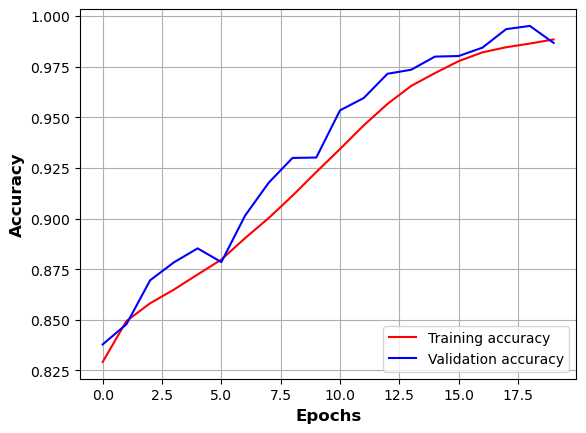

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy', markersize=5)
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', markersize=5)
plt.grid(True)
plt.xlabel('Epochs', fontsize=12, fontweight='bold')  # Bold and increase font size for x-axis label
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')  # Bold and increase font size for y-axis label
plt.legend(loc='lower right')
plt.show()

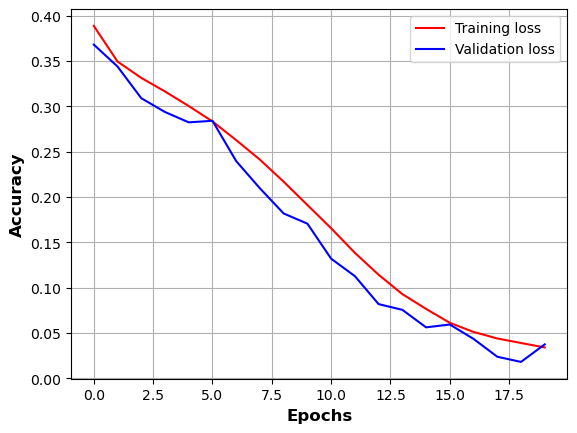

In [14]:
plt.plot(epochs, loss, 'r', label='Training loss', markersize=5)  # Increase markersize
plt.plot(epochs, val_loss, 'b', label='Validation loss', markersize=5)  # Increase markersize
plt.xlabel('Epochs', fontsize=12, fontweight='bold')  # Bold and increase font size for x-axis label
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')  # Bold and increase font size for y-axis label
plt.grid(True)  # Turn on grid
plt.legend(loc=0)
plt.show()